# TD n°1 : Introduction to PyTorch 
---

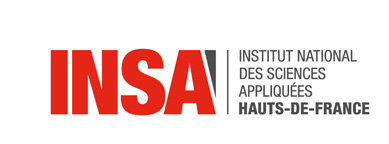


S. Delprat, INSA Hauts-de-France

The main objective of this exercise session is to understand how to use pytorch tensors to perform a basic 1D curve fitting. 

---


In [41]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU is accessible: {gpu_name}")

GPU is accessible: NVIDIA GeForce GTX 1050


## I) Import & visualize data

**Q1.** Retrieve data

1.   Copy the file "dataTD1.csv" on your Google Drive
2.   Share that file using a link and note the link URL
3.   Use gdown to copy the file into the current Colab machine



In [43]:
# We run locally

**Q2.** Use panda to download the csv

In [44]:
df = pd.read_csv('../data/raw/dataTD1.csv')
df.head(10)

,x,y
0,0.155979,-37.178381
1,7.133130,131.170169
2,-2.313728,104.336277
3,3.913819,97.426606
4,2.558084,-143.761992
5,-0.992237,84.310260
6,-0.527641,39.972846
7,8.994127,331.946154
8,-8.330049,-459.754159
9,-4.403422,3.603814


**Q3.** Use the describe method of the dataframe to display information about the data

In [45]:
df.describe()

,x,y
count,300.000000,300.000000
mean,0.277910,-27.653652
std,5.769276,246.521342
min,-9.913299,-878.033396
25%,-4.480942,-68.372027
50%,0.122460,23.915739
75%,5.459625,95.380362
max,9.824064,464.147759


**Q4.** Convert data from the dataframe to float 32 tensors



In [46]:
X = torch.tensor(df['x'].values, dtype=torch.float32)
y = torch.tensor(df['y'].values, dtype=torch.float32)

**Q5.** Visualize the data using matplotlib

In [47]:
# Seaborn Plot
def sns_plot_data(x, y, label='y as a function of x'):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y, color='blue', label=label)
    plt.title('Seaborn Scatter Plot of x vs y')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

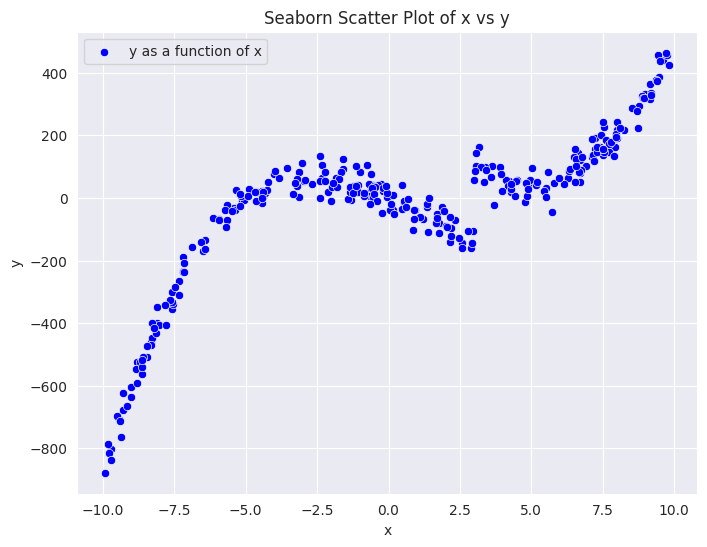

In [48]:
sns_plot_data(X, y)

In [49]:
# Scaling the values between -1 and 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
scaled_X_y = scaler.transform(df)

In [50]:
display(scaled_X_y)

array([[-2.11698315e-02, -3.87010813e-02],
       [ 1.19021408e+00,  6.45336383e-01],
       [-4.49964229e-01,  5.36304336e-01],
       [ 6.31272202e-01,  5.08228808e-01],
       [ 3.95887347e-01, -4.71773917e-01],
       [-2.20524915e-01,  4.54934188e-01],
       [-1.39861065e-01,  2.74781449e-01],
       [ 1.51332342e+00,  1.46113371e+00],
       [-1.49452743e+00, -1.75572012e+00],
       [-8.12780203e-01,  1.27006014e-01],
       [-2.32264669e-01,  2.77672224e-01],
       [ 2.55834060e-01, -2.19151178e-01],
       [ 1.26305757e+00,  1.03428918e+00],
       [-1.55547503e-01,  2.30357350e-01],
       [-2.65561238e-01,  2.67588487e-01],
       [ 8.06609212e-01,  3.12545850e-01],
       [-1.59679886e-01,  1.35886702e-01],
       [ 1.20469715e+00,  8.96905090e-01],
       [-1.64535920e-01,  2.92180541e-01],
       [-5.48332100e-02,  1.27636008e-01],
       [-9.18973648e-02,  2.89308172e-01],
       [-9.87652367e-01, -1.27383613e-02],
       [-1.48739273e+00, -1.70390526e+00],
       [-1.

In [51]:
X = torch.tensor(scaled_X_y[:,0], dtype=torch.float32)
y = torch.tensor(scaled_X_y[:,1], dtype=torch.float32)

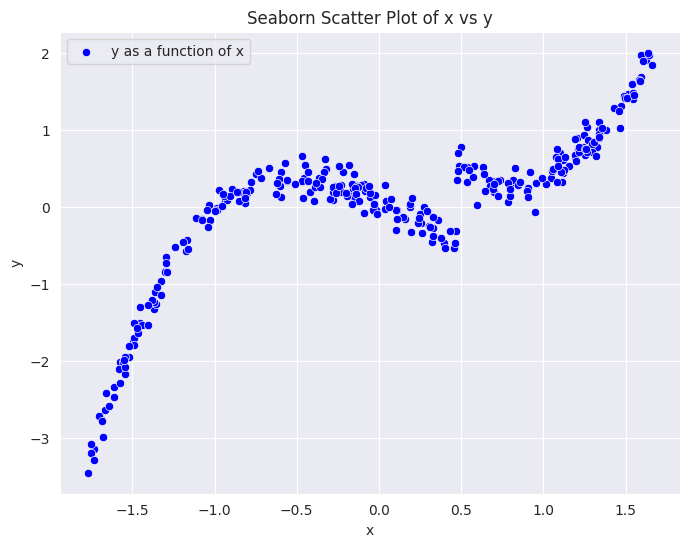

In [52]:
sns_plot_data(X, y)

## 2) dataset & data loader creation

### 2.1) datasets creation

**Q6.** Write a custom dataset class to produce data sample $(x_i,y_i)$

In [53]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, input_data, labels):
        self.x = input_data
        self.y = labels
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

**Q7.** Create a dataset object for the whole data set

In [54]:
dataset = MyDataset(X, y)

**Q8.** Split data into test, validation and train using torch.utils.data.random_split

In [55]:
from torch.utils.data import random_split
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

**Q9.** Display the data of every individual dataset

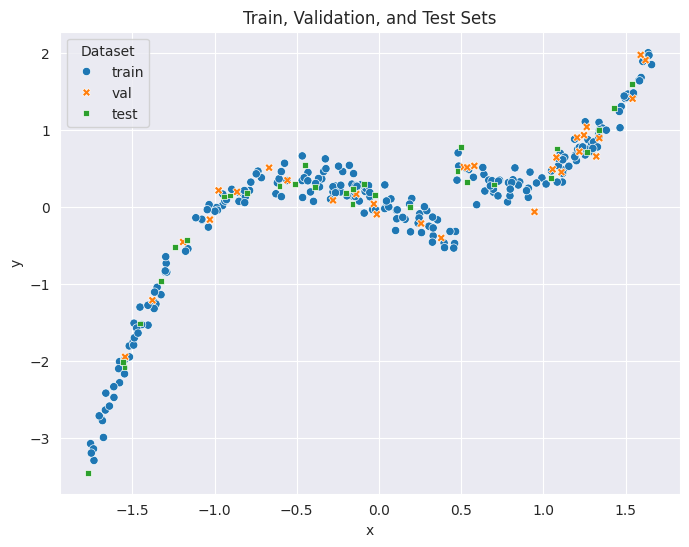

In [56]:
# Function to extract data from the dataset split
def extract_data(dataset_split):
    x_values, y_values = [], []
    for x_value, y_value in dataset_split:
        x_values.append(x_value.item())
        y_values.append(y_value.item())
    return x_values, y_values

# Extract data from each split
train_x, train_y = extract_data(train_set)
val_x, val_y = extract_data(val_set)
test_x, test_y = extract_data(test_set)


# Combine the data into a DataFrame for easier plotting
data = {
    'x': train_x + val_x + test_x,
    'y': train_y + val_y + test_y,
    'set': (['train'] * len(train_x)) + (['val'] * len(val_x)) + (['test'] * len(test_x))
}
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='x', y='y', hue='set', style='set')
plt.title('Train, Validation, and Test Sets')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title='Dataset')
plt.grid(True)
plt.show()

### 2.2) Data loaders creation

**Q10.** Create a data loader for each sub-dataset

In [57]:
batchSize=64

In [58]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=batchSize, shuffle=True)#, num_workers=4, prefetch_factor=1)
val_loader = DataLoader(dataset, batch_size=batchSize, shuffle=True)#, num_workers=4, prefetch_factor=1)
test_loader = DataLoader(dataset, batch_size=batchSize, shuffle=False)#, num_workers=4, prefetch_factor=1)

## 3) Model

**Q11.** Let us first design a very simple model consisting in a single hidden layer followed by ReLu.
In the __init__ method define and store the layers and in the __forward__ method compute the model output given its input

In [59]:
from torch import nn

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyModel, self).__init__()
        # Define the layers with appropriate dimensions
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.output_layer(self.relu(self.hidden_layer(x)))

In [60]:
model1 = MyModel(input_size=1, hidden_size=10, output_size=1)

## 4) Train the model

In order to train the model, you need to write some code to:


1.   Iterate over a given number of epoch
2.   Iterate over the available batch within one epoch
3.   Optimize the model by computing gradients over one batch and taking a step
4.   At every epoch, compute the model performance over the validation data
5.   Store model performance (training & validation)
6.   Display training curves : training & validation metrics
7.   Finally display predicted curve vs test data (as well as metric over test data)




**Q12.** Define all the needed variables (max number of epochs, learning rate, etc.) and initialize arrays to solve model loss over training & validation dataset


In [61]:
n_epochs = 1000
learning_rate = 1e-3

**Q13.** Define a relevant loss function

In [62]:
mse_loss = nn.MSELoss()

**Q14.** Define an optimizer (Adam)

In [63]:
opt = torch.optim.Adam(model1.parameters(), lr=learning_rate)

**Q15.** Program the main training loops

A few tips:


*   As the dataset provide scalar values, the dataloader is outputting batches with only one dimension. Use "unsqueeze_" to make sure that the batch have (batchSize,1) dimension
*   Although this may not be necessary here, it is a good practice to use model.eval() before the validation computation and put it on model.train() at the end of the validation computation
*   As the validation computation is not used to compute any gradient, use   with torch.no_grad():




In [64]:
import torch
from tqdm import tqdm

def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device):
    model.to(device)
    model.train()
    losses = []

    # Training loop
    for batch_X, batch_y in data_loader:
        # Send to device
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Predict, Compute Loss, Back Propagate, Optimize, and Update Metrics
        optimizer.zero_grad() # Reset gradients for new pass
        predictions = model(batch_X.unsqueeze(1))
        loss = criterion(predictions, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return sum(losses) / len(losses) # return the average training loss


def validate(model: nn.Module, criterion: nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device):
    model.to(device)
    model.eval()
    losses = []
    
    # We do not need to keep track of the gradients
    with torch.no_grad():
        # Validation loop
        for batch_X, batch_y in data_loader:
            # Send to device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Predict, Compute Loss, and Update Metrics
            predictions = model(batch_X.unsqueeze(1))
            loss = criterion(predictions, batch_y.unsqueeze(1))
            losses.append(loss.item())

    return sum(losses) / len(losses) # return the average validation loss


def train_with_validation(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        criterion: nn.Module,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        device: torch.device,
        n_epochs: int
):
    train_losses, val_losses = [], []
    prev_train_loss, prev_val_loss = None, None

    # Epoch loop with tqdm progress bar
    epoch_progress = tqdm(range(1, n_epochs + 1), desc="Epochs")
    for _ in epoch_progress:
        # Perform training and validation pass
        train_loss = train(model, optimizer, criterion, train_loader, device)
        val_loss = validate(model, criterion, val_loader, device)
        
        # Update history
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Calculate improvements
        train_improvement = prev_train_loss - train_loss if prev_train_loss is not None else 0
        val_improvement = prev_val_loss - val_loss if prev_val_loss is not None else 0
    
        # Update metrics
        prev_train_loss = train_loss
        prev_val_loss = val_loss

        # Update epoch progress bar with losses and improvements
        epoch_progress.set_postfix({
            'Train Loss': f"{train_loss:.4f}",
            'Val Loss': f"{val_loss:.4f}",
            'Train Imp': f"{train_improvement:.4f}",
            'Val Imp': f"{val_improvement:.4f}"
        })

    return train_losses, val_losses

In [65]:
training_losses, validation_losses = train_with_validation(
    model=model1,
    optimizer=opt,
    criterion=mse_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    n_epochs=n_epochs
)

Epochs: 100%|██████████| 1000/1000 [00:17<00:00, 57.01it/s, Train Loss=0.0311, Val Loss=0.0315, Train Imp=0.0009, Val Imp=0.0001] 


**Q16.** Display training curves

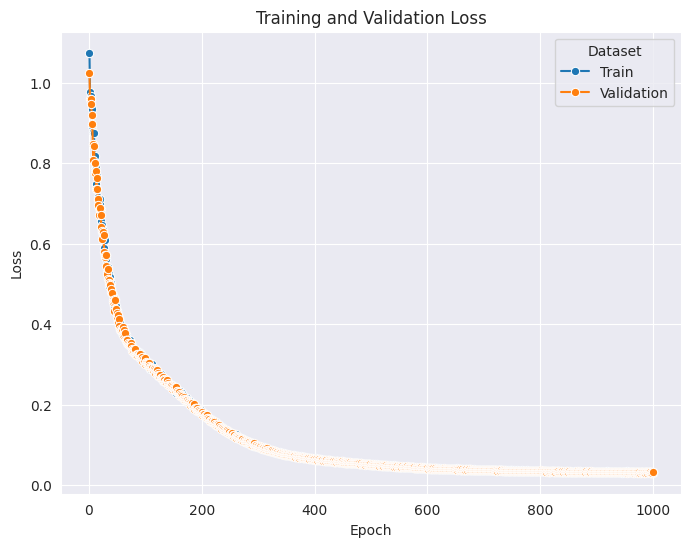

In [66]:
epochs = list(range(1, len(training_losses) + 1))  # Epoch numbers

# Prepare data for plotting
data = pd.DataFrame({
    'Epoch': epochs + epochs,  # Duplicate epoch numbers for train and val
    'Loss': training_losses + validation_losses,
    'Set': ['Train'] * len(training_losses) + ['Validation'] * len(validation_losses)  # Labels
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=data, x='Epoch', y='Loss', hue='Set', marker='o')

# Customize the plot
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.grid(True)
plt.show()

**Q17.** Compute the loss over the test dataset

In [67]:
# Define the validation function
def test(model: nn.Module, criterion: nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    test_losses = []  # Initialize an empty list to store validation losses

    with torch.no_grad():  # Disable gradient calculation for validation
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to('cuda'), batch_y.to('cuda')
            predictions = model(batch_X.unsqueeze(1))
            loss = criterion(predictions, batch_y.unsqueeze(1))
            test_losses.append(loss.item())
            
    return sum(test_losses) / len(test_losses)

In [68]:
test(model=model1, criterion=mse_loss, data_loader=train_loader, device=torch.device('cuda'))

0.03280720561742782

**Q18.** Compute the model curve over the min & max value contained in the whole dataset (X loaded in Q4)

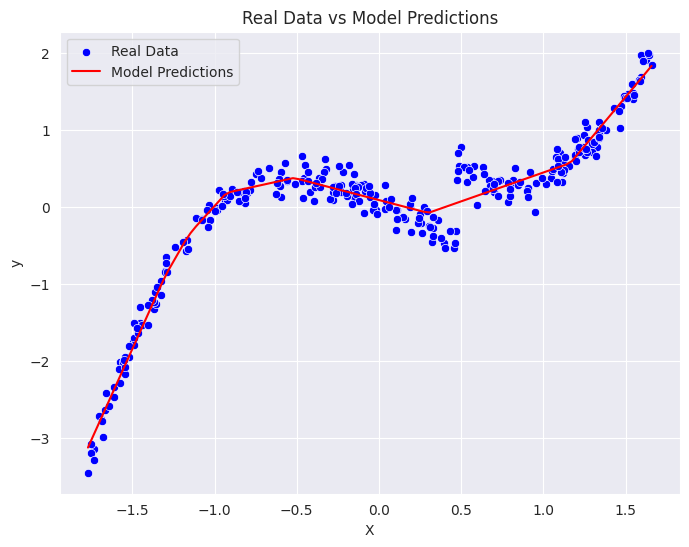

In [69]:
# Find the range of X
X_min, X_max = X.min().item(), X.max().item()
# Generate a range of X values for predictions
X_pred = torch.linspace(X_min, X_max, 100).reshape(-1, 1)  # Smooth X values

# Move the model to device if available
if torch.cuda.is_available():
    model1.to('cuda')
    X_pred.to('cuda')
    
# Predict using the trained model
model1.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradient calculation needed
    y_hat = model1(X_pred.to('cuda')).squeeze()  # Get model predictions

# Plot the real data and model predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X, y=y, color='blue', label='Real Data') # Scatter plot for real data
sns.lineplot(x=X_pred.squeeze().cpu(), y=y_hat.cpu(), color='red', label='Model Predictions') # Line plot for model predictions
plt.title('Real Data vs Model Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

**Q19.** It may be difficult to capture the discontinuity occurring at x=2.5. Modify the model such that the discontinuity is captured

In [76]:
from torch import nn

class DiscontinuityModel(nn.Module):
    def __init__(self):
        super(DiscontinuityModel, self).__init__()
        # Define a deeper neural network
        self.net = nn.Sequential(
            nn.Linear(1, 24),   # First layer
            nn.ReLU(),          # Activation
            nn.Linear(24, 32), 
            nn.ReLU(),
            nn.Linear(32, 12), 
            nn.ReLU(),
            nn.Linear(12, 1)    # Output layer
        )
        
    def forward(self, x):
        return self.net(x)

In [77]:
# Define the model, loss function, and optimizer
model2 = DiscontinuityModel()
mse_loss = nn.MSELoss()
opt = torch.optim.Adam(model2.parameters(), lr=0.001)

# Training loop
epochs = 1000
training_losses = []
validation_losses = []

In [78]:
training_losses, validation_losses = train_with_validation(
    model=model2,
    optimizer=opt,
    criterion=mse_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    n_epochs=epochs
)

Epochs: 100%|██████████| 1000/1000 [00:23<00:00, 43.43it/s, Train Loss=0.0188, Val Loss=0.0182, Train Imp=-0.0003, Val Imp=-0.0003]


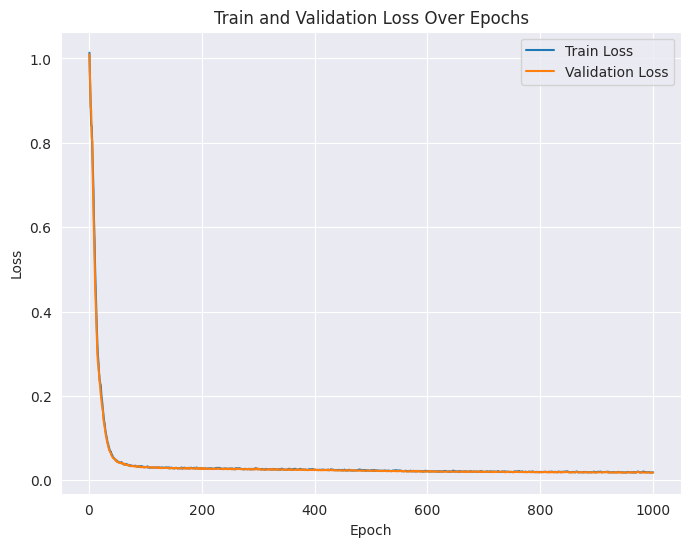

In [79]:
# Plot train and validation loss
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, epochs + 1), y=training_losses, label='Train Loss')
sns.lineplot(x=range(1, epochs + 1), y=validation_losses, label='Validation Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
test(model=model2, criterion=mse_loss, data_loader=train_loader, device=torch.device('cuda'))

0.01796300318092108

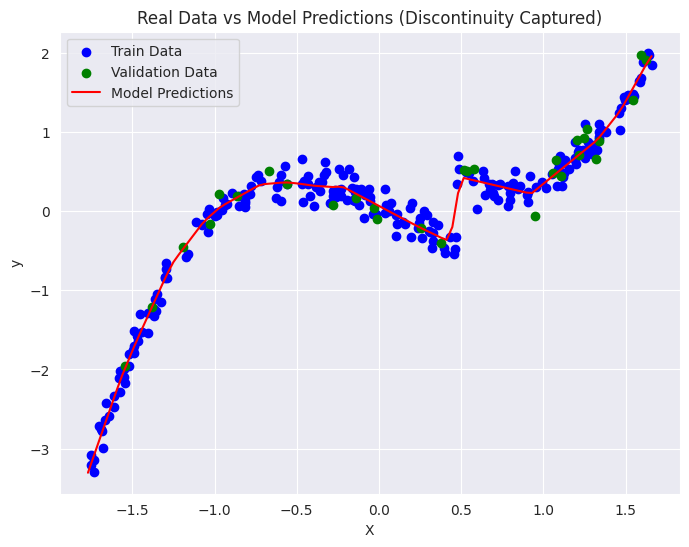

In [81]:
# Plot after training
with torch.no_grad():
    model2.eval()
    y_pred = model2(X_pred.to('cuda').unsqueeze(1)).squeeze()  # Predictions over the full range
    plt.figure(figsize=(8, 6))
    plt.scatter(train_x, train_y, color='blue', label='Train Data')
    plt.scatter(val_x, val_y, color='green', label='Validation Data')
    plt.plot(X_pred.cpu(), y_pred.cpu(), color='red', label='Model Predictions')
    plt.title('Real Data vs Model Predictions (Discontinuity Captured)')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()